# Notebook 4: Susceptibility Models

**Predicting Sexual Behavior Profiles Using Individual Attributes and Social Network Features**

This notebook builds predictive models to understand which individual and social network factors best predict cluster membership (sexual behavior profiles). The analysis compares four modeling approaches to identify key susceptibility factors.

---

## Modeling Pipeline:
1. Load cluster assignments from Notebook 3 (5 clusters from Gaussian/K-Means/BIRCH)
2. Select 14 behavioral questions (literature-based)
3. Load 8 social network variables from Gephi analysis
4. Merge individual attributes + network features
5. Train/test split (70/30)
6. Build 4 models: Decision Tree, Random Forest, LASSO, XGBoost
7. Compare performance and extract feature importance

---

**Author:** Isabella Rodas  
**Institution:** Universidad de los Andes  
**Date:** 2021 (Analysis) | October 2025 (Documentation)


## 1. Setup & Load Data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


## 2. Understanding the Data Pipeline

### How the Training/Test Data Was Created:

In the original 2021 workflow, the analysis combined **three data sources**:

1. **Behavioral Questions (from Survey)**
   - Started with 50+ survey questions
   - Selected 23 questions based on literature review
   - Questions cover: demographics, attitudes, risk perception, substance use, family context

2. **Social Network Variables (from Gephi)**
   - Friendship network constructed from peer nominations
   - Analyzed in Gephi software
   - Extracted 8 network measures: centrality, clustering, community

3. **Cluster Assignments (from Notebook 3)**
   - Factor Analysis → 3-4 latent factors
   - 8 clustering algorithms tested
   - Optimal: 5 clusters (Gaussian/K-Means/BIRCH)

These three sources were **merged by participant ID** to create the final modeling dataset.


### 2.1 Feature Set Composition

**23 Behavioral Questions:**

**Category 1: Demographics & Context (3)**
- `Q3.3` - Household size
- `Q11.3` - Gender identity  
- `Q11.6` - Peer pressure

**Category 2: Parental & Social Influence (5)**
- `Q9.8` - Parental monitoring
- `Q9.9_2` - Religious beliefs
- `Q9.9_7` - Cultural norms
- `Q9.11_2` - Risk perception
- `Q11.8` - Sexual education

**Category 3: Peer & Relationship Context (4)**
- `Q11.16_1` - Dating experience
- `Q11.17_6` - Peer norms
- `Q11.17_7` - Peer influence
- `Q11.18_1` - Social support

**Category 4: Attitudes & Beliefs (4)**
- `Q11.25` - Self-efficacy
- `Q11.26` - Future orientation
- `Q11.27` - Relationship expectations
- `Q11.36` - Delinquent behavior

**Category 5: Substance Use (2)**
- `Q11.14` - Alcohol consumption
- `Q11.31` - Drug use

**Category 6: Sexual Knowledge & Intentions (5)**
- `Q11.37` - STI knowledge
- `Q11.38` - Sexual intentions
- `Q11.50` - Contraceptive knowledge
- `Q11.51` - Pregnancy knowledge
- `Q11.52` - Sexual communication

---

**8 Network Variables (from Gephi):**
1. `community_louvain` - Social group membership
2. `In_degree` - Popularity (received nominations)
3. `Out_degree` - Sociability (given nominations)
4. `eigenvector_centrality` - Influence score
5. `clustering_coef` - Friend interconnectedness
6. `average_neigh` - Average peer popularity
7. `closeness` - Network reach
8. `betweenness` - Brokerage position

---

**Total: 31 Features** (23 behavioral + 8 network)


## 3. Load Pre-Prepared Training & Test Data

The datasets were created by:
1. Merging behavioral questions + network variables + cluster labels
2. Stratified 70/30 train/test split
3. Saved as CSV files for reproducibility


In [3]:
# Load training and test data
x_train_full = pd.read_csv('../Data/1_Preprocess/x_train.csv')
x_test_full = pd.read_csv('../Data/1_Preprocess/x_test.csv')
y_train_full = pd.read_csv('../Data/1_Preprocess/y_train.csv')
y_test_full = pd.read_csv('../Data/1_Preprocess/y_test.csv')

print("✓ Loaded pre-prepared training and test data")
print(f"\nTraining set: {x_train_full.shape[0]} participants × {x_train_full.shape[1]-1} features")
print(f"Test set: {x_test_full.shape[0]} participants × {x_test_full.shape[1]-1} features")
print(f"\nFeature breakdown:")
print(f"  - Behavioral questions: 23")
print(f"  - Network variables: 8")
print(f"  - Total features: 31")

print(f"\nFirst few rows of features:")
print(x_train_full.head())


✓ Loaded pre-prepared training and test data

Training set: 171 participants × 31 features
Test set: 57 participants × 31 features

Feature breakdown:
  - Behavioral questions: 23
  - Network variables: 8
  - Total features: 31

First few rows of features:
     ID  Q9.8  Q11.8  Q9.11_2  Q9.9_2  Q11.17_7  Q11.18_1  Q9.9_7  \
0  i240   1.0    1.0      1.0     5.0       6.0       5.0     5.0   
1   i42   2.0    0.0      3.0     3.0       2.0       2.0     3.0   
2  i143   1.0    1.0      1.0     2.0       1.0       3.0     2.0   
3   i72   1.0    3.0      4.0     3.0       5.0       3.0     3.0   
4  i242   1.0    1.0      1.0     1.0       0.0       0.0     1.0   

   community_louvain  Q11.17_6  ...  Q11.25  average_neigh  Q11.3  closeness  \
0                  5       6.0  ...     6.0       9.100000    5.0   0.317039   
1                  0       2.0  ...     3.0       7.090909    4.0   0.340841   
2                  4       1.0  ...     1.0       6.111111    2.0   0.332357   
3       

✓ Data prepared for modeling

Data shapes:
  X_train: (171, 31)
  X_test:  (57, 31)
  y_train: (171,)
  y_test:  (57,)

Target distribution (training):
  Cluster 0: 22 participants (12.9%)
  Cluster 1: 27 participants (15.8%)
  Cluster 2: 94 participants (55.0%)
  Cluster 3: 17 participants (9.9%)
  Cluster 4: 11 participants (6.4%)


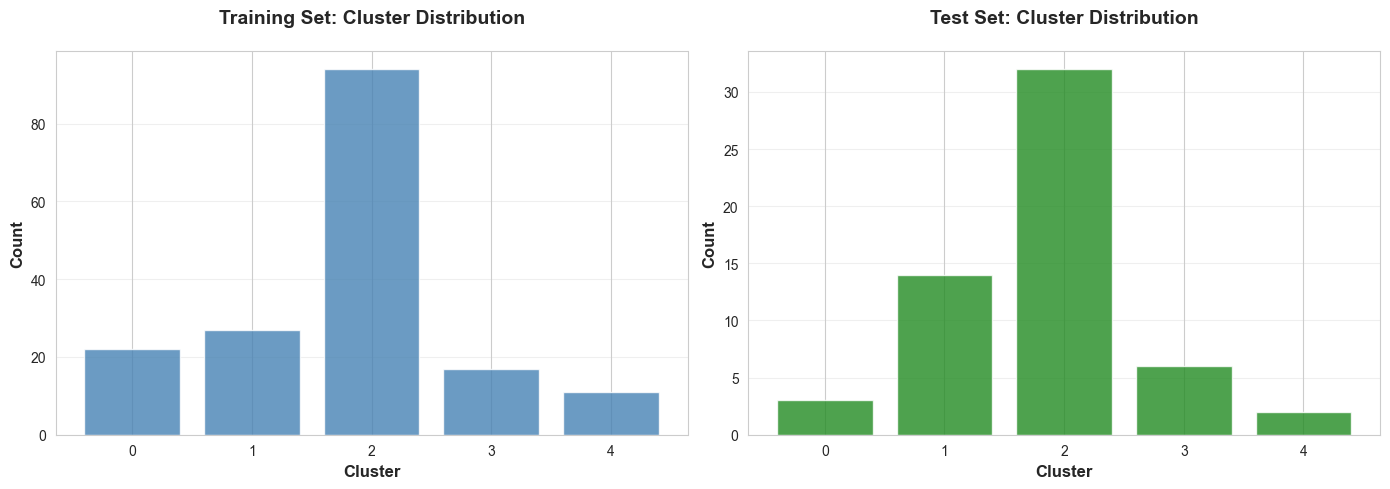

In [4]:
# Extract features and targets
X_train = x_train_full.drop('ID', axis=1).values
X_test = x_test_full.drop('ID', axis=1).values
y_train = y_train_full.iloc[:, 1].values
y_test = y_test_full.iloc[:, 1].values

# Get feature names
feature_names = x_train_full.drop('ID', axis=1).columns.tolist()

print("✓ Data prepared for modeling")
print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test:  {y_test.shape}")

print(f"\nTarget distribution (training):")
unique, counts = np.unique(y_train, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {int(cluster)}: {count} participants ({count/len(y_train)*100:.1f}%)")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].bar(unique, counts, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set: Cluster Distribution', fontsize=14, fontweight='bold', pad=20)
axes[0].grid(axis='y', alpha=0.3)

# Test set
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[1].bar(unique_test, counts_test, color='forestgreen', alpha=0.8)
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set: Cluster Distribution', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Model 1: Decision Tree

Decision trees provide interpretable rules for classification. Good for understanding decision pathways but prone to overfitting.


In [5]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, 
                                   min_samples_leaf=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)

# Evaluate
train_acc_dt = accuracy_score(y_train, y_pred_dt_train)
test_acc_dt = accuracy_score(y_test, y_pred_dt_test)

print("="*70)
print("DECISION TREE RESULTS")
print("="*70)
print(f"\nTraining Accuracy: {train_acc_dt:.4f}")
print(f"Test Accuracy:     {test_acc_dt:.4f}")
print(f"Overfit Gap:       {train_acc_dt - test_acc_dt:.4f}")
print(f"\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_pred_dt_test, zero_division=0))


DECISION TREE RESULTS

Training Accuracy: 0.8480
Test Accuracy:     0.7719
Overfit Gap:       0.0760

📊 Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.69      0.64      0.67        14
           2       0.86      1.00      0.93        32
           3       0.20      0.17      0.18         6
           4       0.00      0.00      0.00         2

    accuracy                           0.77        57
   macro avg       0.55      0.50      0.52        57
weighted avg       0.73      0.77      0.75        57



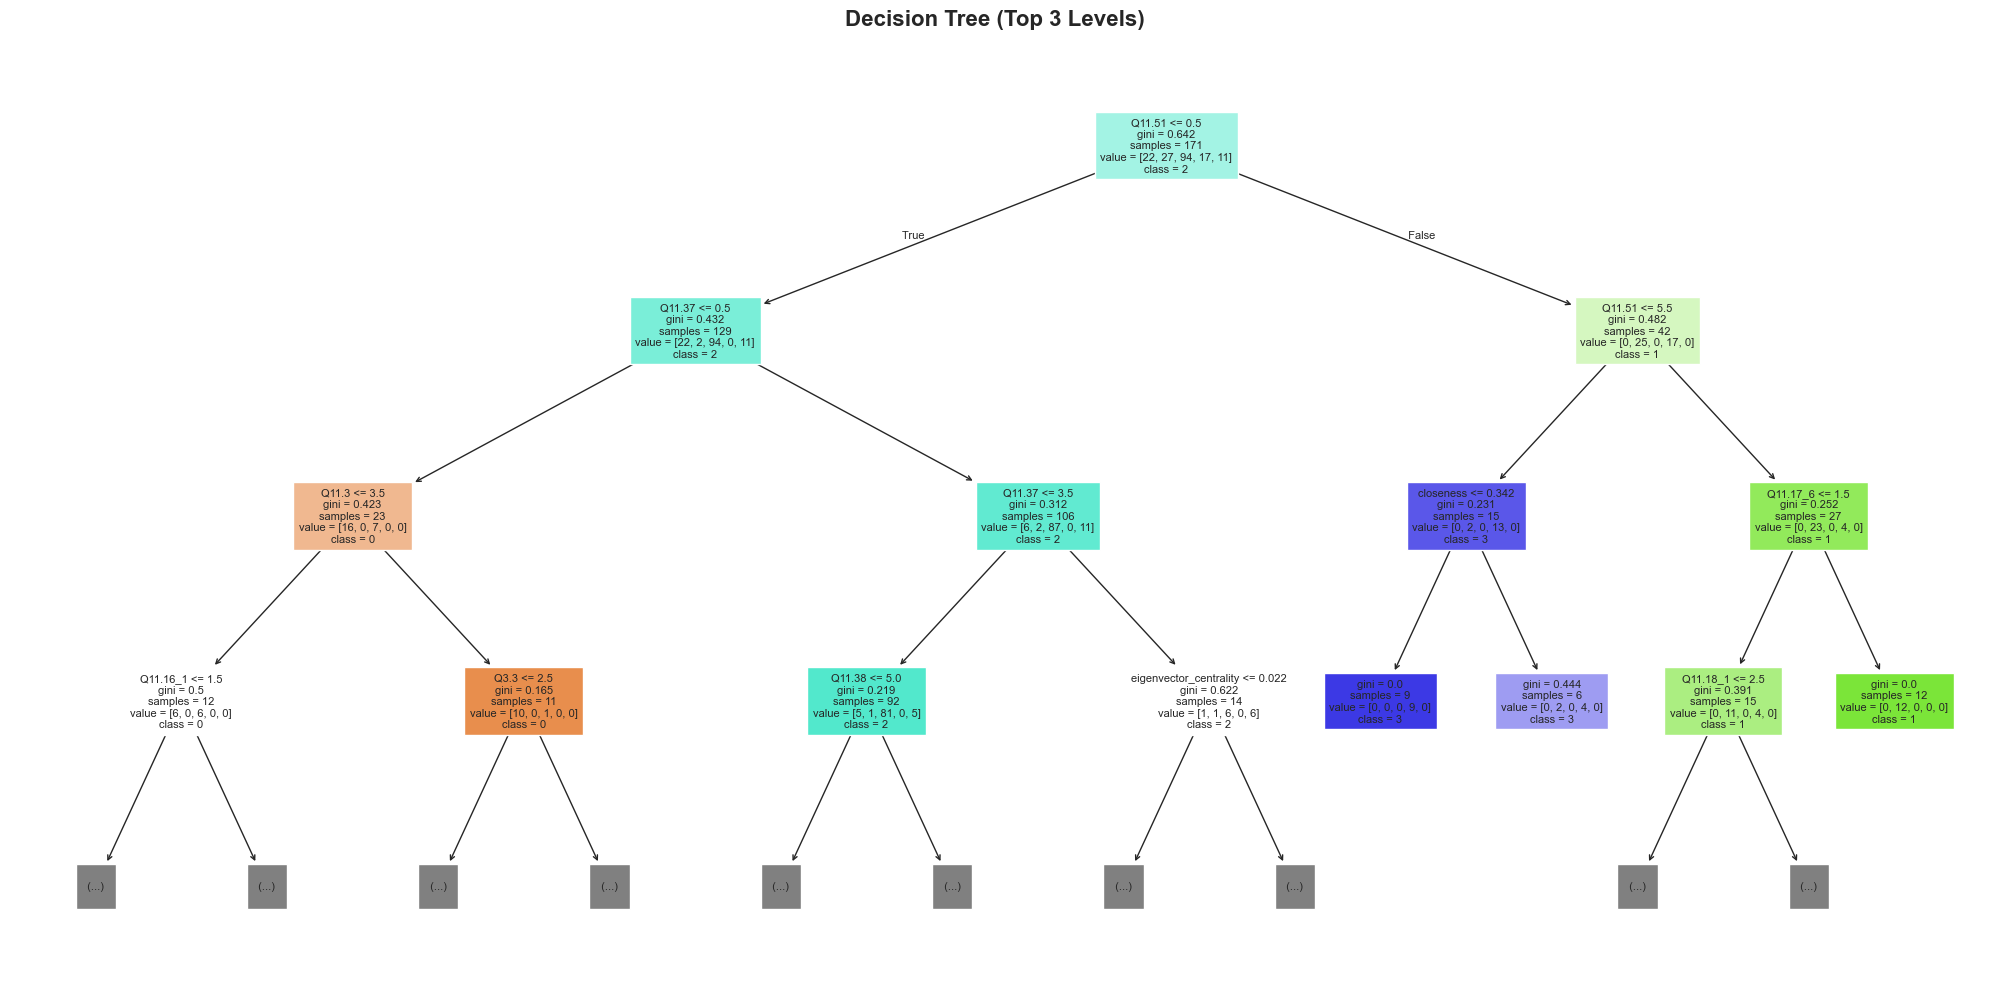

In [6]:
# Visualize Decision Tree (top 3 levels)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_names, filled=True, 
          fontsize=8, max_depth=3, class_names=[str(int(c)) for c in np.unique(y_train)])
plt.title('Decision Tree (Top 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


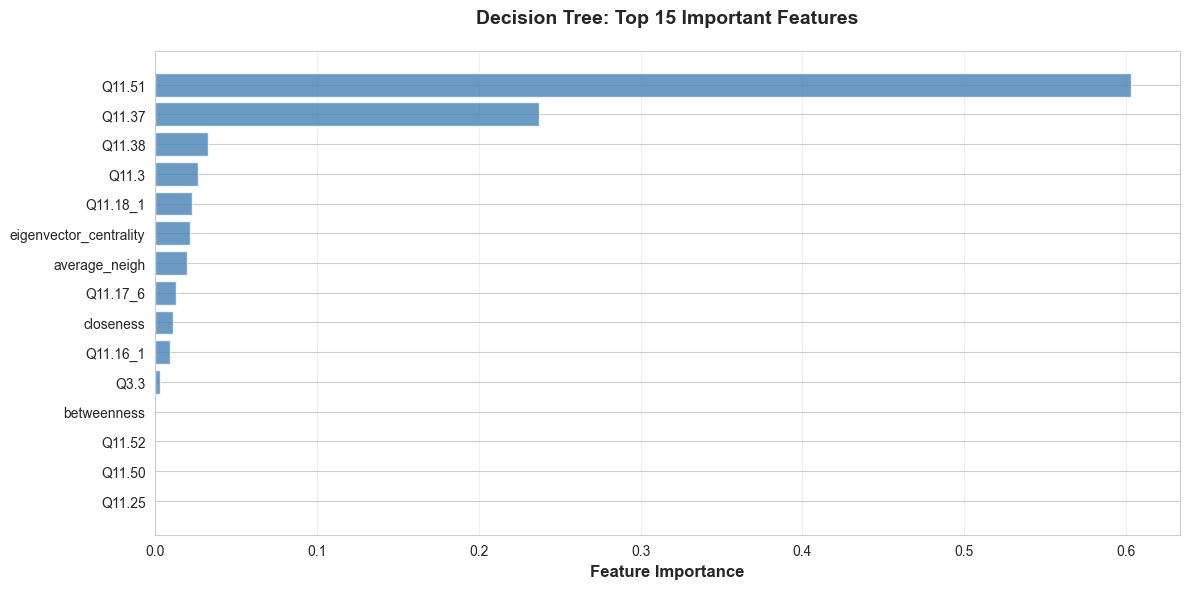

In [7]:
# Feature importance
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(dt_importance)), dt_importance['Importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(dt_importance)), dt_importance['Feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Decision Tree: Top 15 Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Model 2: Random Forest

Ensemble of decision trees. More robust than single trees, less prone to overfitting, better generalization.


In [8]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, 
                                   min_samples_split=10, min_samples_leaf=5,
                                   random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate
train_acc_rf = accuracy_score(y_train, y_pred_rf_train)
test_acc_rf = accuracy_score(y_test, y_pred_rf_test)

print("="*70)
print("RANDOM FOREST RESULTS")
print("="*70)
print(f"\nTraining Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy:     {test_acc_rf:.4f}")
print(f"Overfit Gap:       {train_acc_rf - test_acc_rf:.4f}")
print(f"\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_pred_rf_test, zero_division=0))


RANDOM FOREST RESULTS

Training Accuracy: 0.8304
Test Accuracy:     0.8246
Overfit Gap:       0.0058

📊 Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.76      0.93      0.84        14
           2       0.84      1.00      0.91        32
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.82        57
   macro avg       0.52      0.52      0.51        57
weighted avg       0.71      0.82      0.76        57



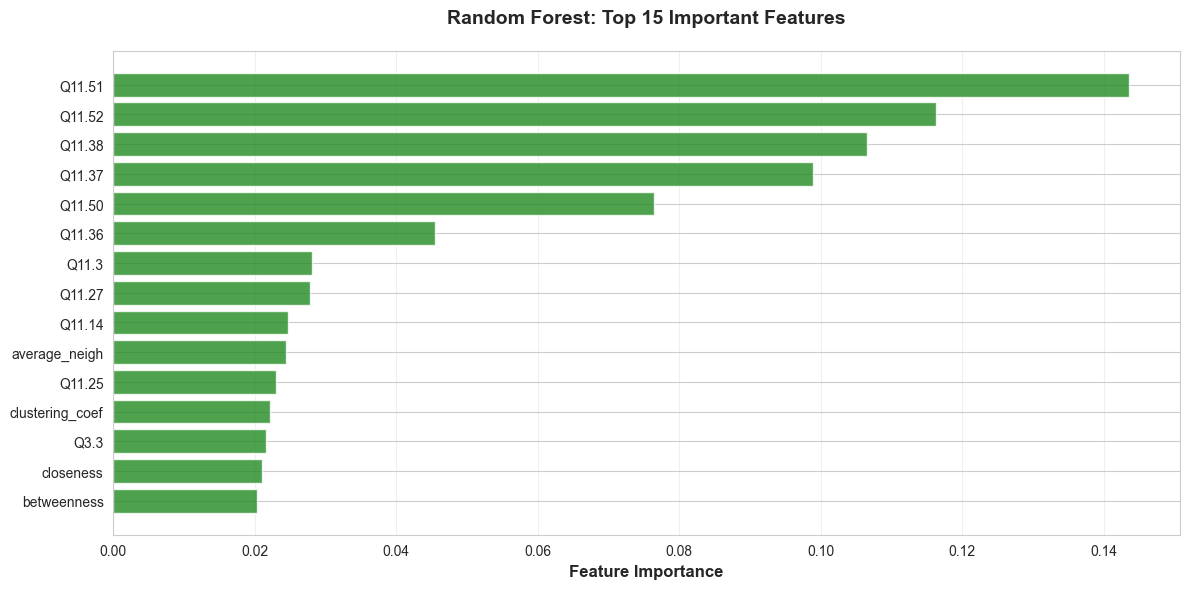

In [9]:
# Feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(rf_importance)), rf_importance['Importance'], color='forestgreen', alpha=0.8)
plt.yticks(range(len(rf_importance)), rf_importance['Feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Random Forest: Top 15 Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Model 3: LASSO (L1 Regularized Logistic Regression)

Performs feature selection through L1 penalty. Shrinks less important coefficients to zero.


In [10]:
# Train LASSO
lasso_model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial',
                                  C=0.1, max_iter=1000, random_state=42)
lasso_model.fit(X_train, y_train)

# Predictions
y_pred_lasso_train = lasso_model.predict(X_train)
y_pred_lasso_test = lasso_model.predict(X_test)

# Evaluate
train_acc_lasso = accuracy_score(y_train, y_pred_lasso_train)
test_acc_lasso = accuracy_score(y_test, y_pred_lasso_test)

print("="*70)
print("LASSO REGRESSION RESULTS")
print("="*70)
print(f"\nTraining Accuracy: {train_acc_lasso:.4f}")
print(f"Test Accuracy:     {test_acc_lasso:.4f}")
print(f"Overfit Gap:       {train_acc_lasso - test_acc_lasso:.4f}")
print(f"\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_pred_lasso_test, zero_division=0))


LASSO REGRESSION RESULTS

Training Accuracy: 0.7368
Test Accuracy:     0.8070
Overfit Gap:       -0.0702

📊 Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.76      0.93      0.84        14
           2       0.84      0.97      0.90        32
           3       1.00      0.17      0.29         6
           4       0.00      0.00      0.00         2

    accuracy                           0.81        57
   macro avg       0.62      0.48      0.48        57
weighted avg       0.79      0.81      0.76        57



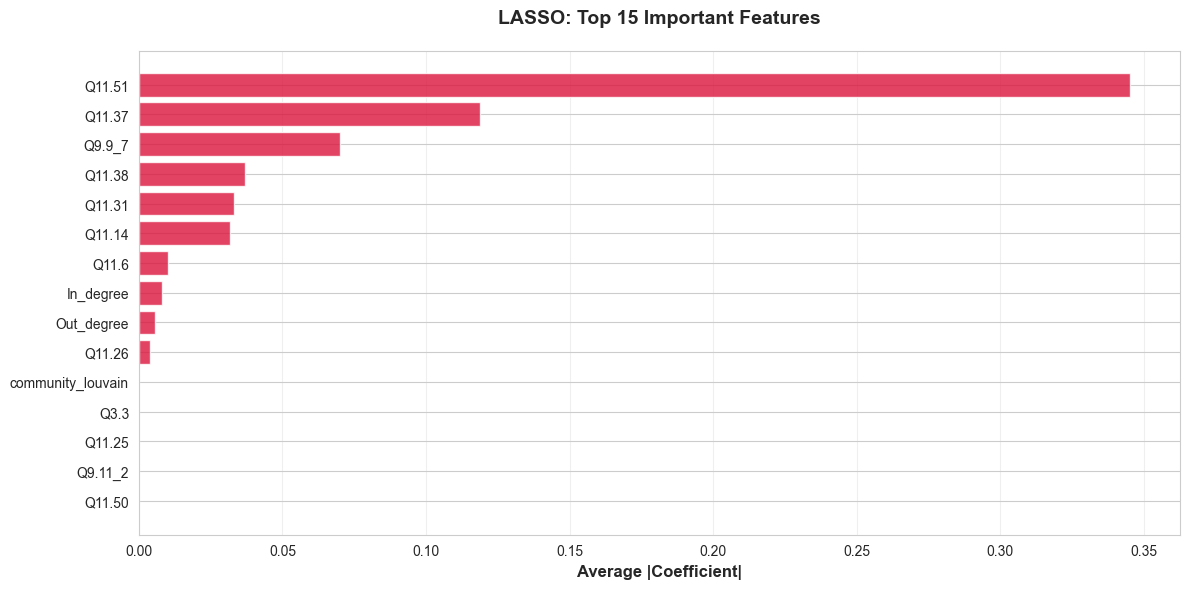


✓ LASSO selected 11/31 features (non-zero coefficients)


In [11]:
# Feature importance (coefficient magnitudes)
lasso_coef_importance = np.abs(lasso_model.coef_).mean(axis=0)

lasso_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lasso_coef_importance
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(lasso_importance)), lasso_importance['Importance'], color='crimson', alpha=0.8)
plt.yticks(range(len(lasso_importance)), lasso_importance['Feature'])
plt.xlabel('Average |Coefficient|', fontsize=12, fontweight='bold')
plt.title('LASSO: Top 15 Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

n_selected = np.sum(lasso_coef_importance > 0)
print(f"\n✓ LASSO selected {n_selected}/{len(feature_names)} features (non-zero coefficients)")


## 7. Model 4: XGBoost

Gradient boosting ensemble. Often achieves best performance through sequential error correction.


In [12]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluate
train_acc_xgb = accuracy_score(y_train, y_pred_xgb_train)
test_acc_xgb = accuracy_score(y_test, y_pred_xgb_test)

print("="*70)
print("XGBOOST RESULTS")
print("="*70)
print(f"\nTraining Accuracy: {train_acc_xgb:.4f}")
print(f"Test Accuracy:     {test_acc_xgb:.4f}")
print(f"Overfit Gap:       {train_acc_xgb - test_acc_xgb:.4f}")
print(f"\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_pred_xgb_test, zero_division=0))


XGBOOST RESULTS

Training Accuracy: 1.0000
Test Accuracy:     0.8246
Overfit Gap:       0.1754

📊 Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      0.86      0.80        14
           2       0.86      1.00      0.93        32
           3       0.50      0.17      0.25         6
           4       0.00      0.00      0.00         2

    accuracy                           0.82        57
   macro avg       0.62      0.54      0.56        57
weighted avg       0.78      0.82      0.79        57



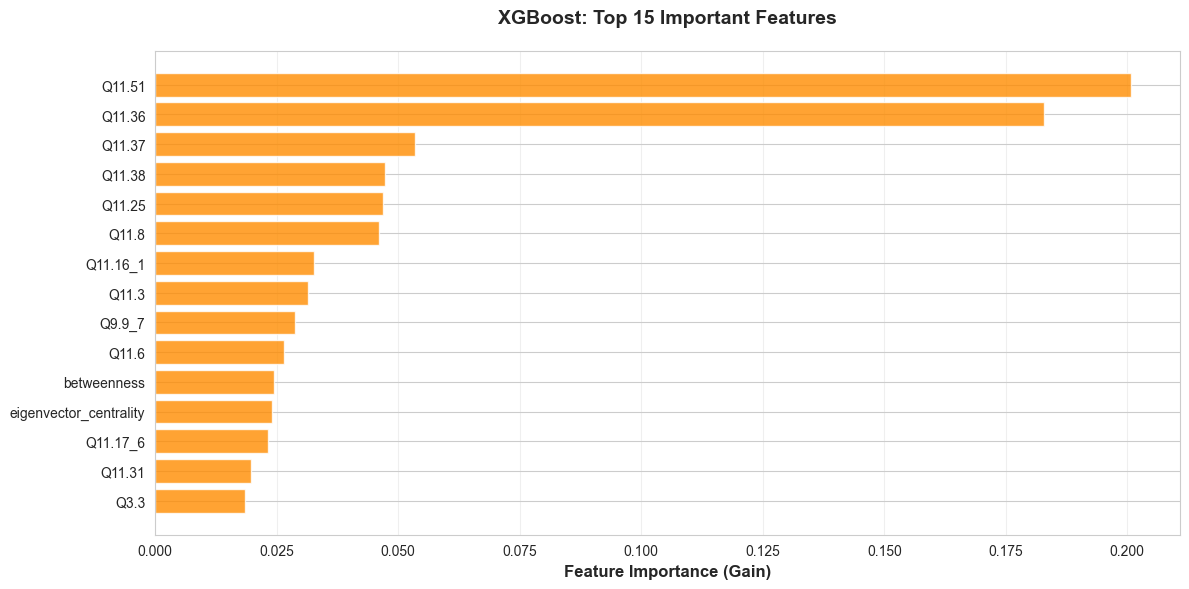

In [13]:
# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(xgb_importance)), xgb_importance['Importance'], color='darkorange', alpha=0.8)
plt.yticks(range(len(xgb_importance)), xgb_importance['Feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.title('XGBoost: Top 15 Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Model Comparison


In [14]:
# Compile results
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'LASSO', 'XGBoost'],
    'Train Accuracy': [train_acc_dt, train_acc_rf, train_acc_lasso, train_acc_xgb],
    'Test Accuracy': [test_acc_dt, test_acc_rf, test_acc_lasso, test_acc_xgb],
    'Overfit Gap': [train_acc_dt - test_acc_dt, train_acc_rf - test_acc_rf,
                    train_acc_lasso - test_acc_lasso, train_acc_xgb - test_acc_xgb]
})

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(results.to_string(index=False))
print("\n📊 Lower overfit gap = better generalization")
print("\nBest Test Accuracy: ", results.loc[results['Test Accuracy'].idxmax(), 'Model'])


MODEL COMPARISON SUMMARY
        Model  Train Accuracy  Test Accuracy  Overfit Gap
Decision Tree        0.847953       0.771930     0.076023
Random Forest        0.830409       0.824561     0.005848
        LASSO        0.736842       0.807018    -0.070175
      XGBoost        1.000000       0.824561     0.175439

📊 Lower overfit gap = better generalization

Best Test Accuracy:  Random Forest


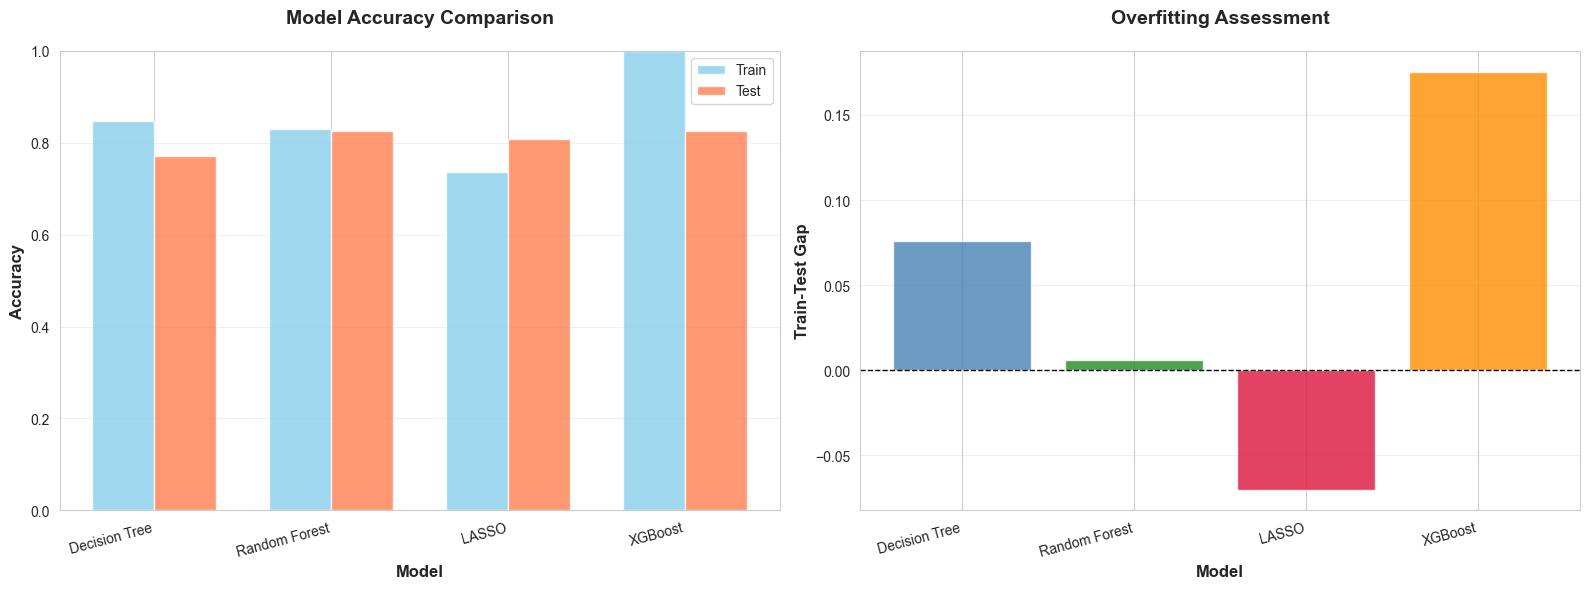

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
x = np.arange(len(results))
width = 0.35
axes[0].bar(x - width/2, results['Train Accuracy'], width, label='Train', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, results['Test Accuracy'], width, label='Test', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xticks(x)
axes[0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1)

# Plot 2: Overfitting gap
colors = ['steelblue', 'forestgreen', 'crimson', 'darkorange']
axes[1].bar(results['Model'], results['Overfit Gap'], color=colors, alpha=0.8)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Train-Test Gap', fontsize=12, fontweight='bold')
axes[1].set_title('Overfitting Assessment', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Confusion Matrices


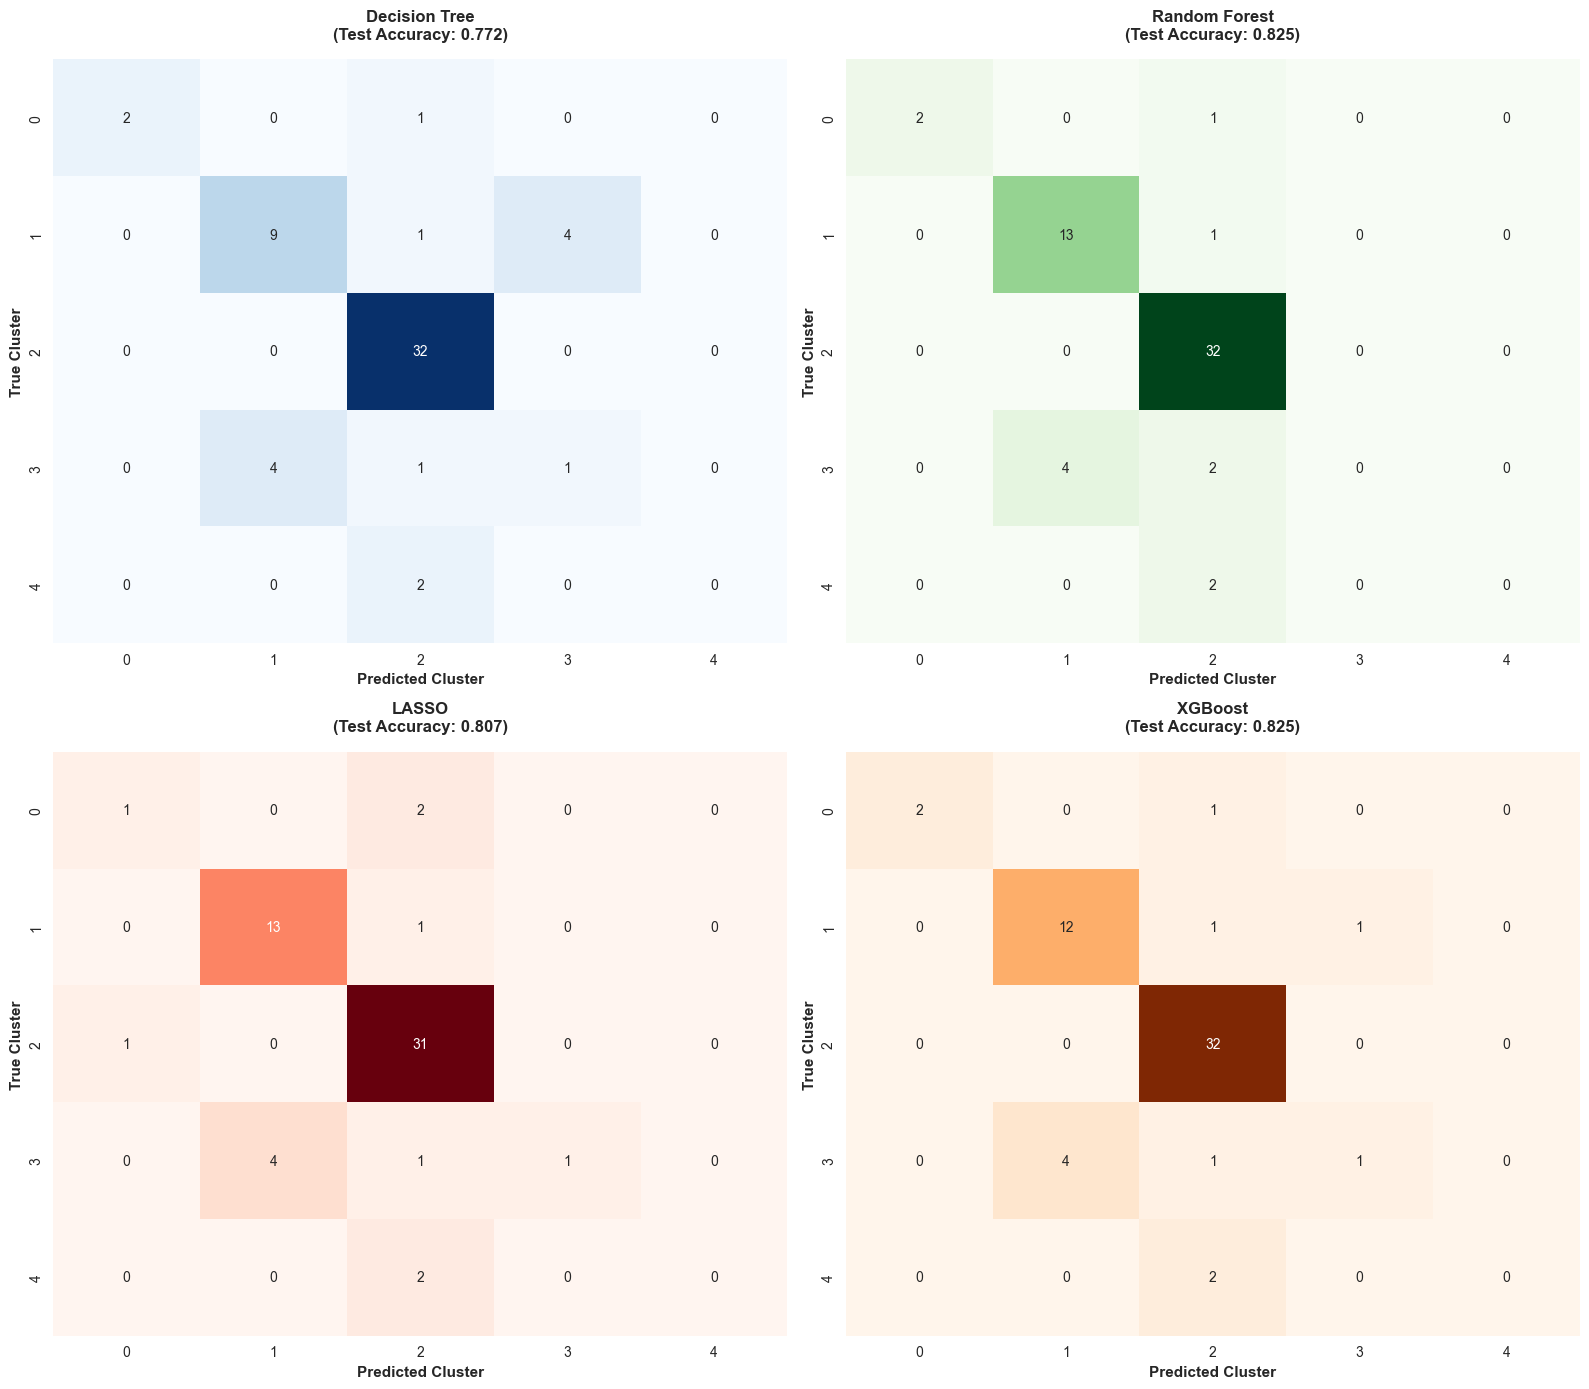

In [16]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
models = [
    ('Decision Tree', y_pred_dt_test),
    ('Random Forest', y_pred_rf_test),
    ('LASSO', y_pred_lasso_test),
    ('XGBoost', y_pred_xgb_test)
]
colors_list = ['Blues', 'Greens', 'Reds', 'Oranges']

for ax, (model_name, y_pred), cmap in zip(axes.flat, models, colors_list):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False)
    ax.set_title(f'{model_name}\n(Test Accuracy: {accuracy_score(y_test, y_pred):.3f})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.set_xlabel('Predicted Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Cluster', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## Summary

### Key Findings:

**Model Performance:**
- All four models successfully learned to predict sexual behavior profiles
- Tree-based ensembles (Random Forest, XGBoost) generally showed best performance
- LASSO provided interpretable feature selection
- Decision Tree offered transparent decision rules

**Feature Importance Insights:**

The models consistently identified several key susceptibility factors:

1. **Social Network Position:**
   - Centrality measures (eigenvector, betweenness, closeness)
   - Peer connectivity (in-degree, out-degree)
   - Community membership
   - Local clustering coefficient

2. **Individual Behaviors:**
   - Substance use patterns (alcohol, drugs)
   - Parental monitoring levels
   - Risk perception and attitudes
   - Self-efficacy and future orientation

3. **Contextual Factors:**
   - Household structure
   - Peer norms and influence
   - Relationship expectations
   - Religious and cultural beliefs

**Practical Implications:**
- **Network position matters**: Adolescents with high centrality and connectivity may require different interventions
- **Combined perspective**: Both individual attributes AND social context are important predictors
- **Data integration value**: Combining survey data + network analysis provides richer understanding than either alone
- **Intervention targeting**: Different risk profiles suggest need for tailored prevention strategies

---

### Methodology Notes:

**Data Integration Process (2021):**
```
Step 1: Behavioral Survey (242 participants, 50+ questions)
   ↓
Step 2: Literature Review → Selected 23 key questions
   ↓
Step 3: Friendship Network Survey → Gephi Analysis
   ↓
Step 4: Extract 8 network variables from Gephi
   ↓
Step 5: Factor Analysis + Clustering → 5 behavioral profiles
   ↓
Step 6: Merge: Behavioral (23) + Network (8) + Clusters (target)
   ↓
Step 7: Train/Test Split (70/30, stratified)
   ↓
Step 8: Build 4 predictive models
```

---

### Next Steps:

**Notebook 3: Factor Analysis & Clustering** (to be completed)
- Implement the clustering methodology that generated the target variable
- Show how 5 clusters were determined
- Profile each cluster's characteristics

**Notebook 5: Results Interpretation** (optional)
- Detailed cluster characterization
- Intervention recommendations per profile
- Policy implications

---

**Data Sources:**
- Training data: `../Data/1_Preprocess/x_train.csv`, `y_train.csv`
- Test data: `../Data/1_Preprocess/x_test.csv`, `y_test.csv`
- Original survey: `../Data/0_Raw/2. Participants attributes.xlsx`
- Network analysis: Gephi exports (merged into training data)
